# **Megaline: Subscriber Data Auditing & Preprocessing**

### **Project Overview**

This project analyzes **subscriber behavior**, **consumption patterns**, and **revenue streams** for Megaline to identify the factors that drive **plan profitability**. Our goal is to provide a data-driven foundation for the company's **commercial strategy** by transforming raw usage logs into **actionable insights**.

**Note:** For a detailed breakdown of the business context, data dictionary, and full project requirements, please refer to the [README.md](https://github.com/fiorellatrigo/estudio_clientes_telefonia/blob/main/README.md).

## **1. Data Preparation and Standardization**

In [369]:
# Load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

In [370]:
# Load Datasets
df_users = pd.read_csv("../data/megaline_users.csv")
df_calls= pd.read_csv("../data/megaline_calls.csv")
df_messages= pd.read_csv("../data/megaline_messages.csv")
df_internet= pd.read_csv("../data/megaline_internet.csv")
df_plans= pd.read_csv("../data/megaline_plans.csv")

In [371]:
# List of our dataframes and their names for auditing
dataframes = {
    'Users': df_users,
    'Calls': df_calls,
    'Messages': df_messages,
    'Internet': df_internet,
    'Plans': df_plans
}

# Quick audit: Checking for missing values and data types across all tables
for name, df in dataframes.items():
    print(f"--- Table: {name} ---")
    print(df.info())
    print(f"Duplicates: {df.duplicated().sum()}")
    print("\n")

--- Table: Users ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
Duplicates: 0


--- Table: Calls ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(

### **1.1. Data Cleaning & Transformation Decisions**

After auditing the datasets, the following steps are taken to ensure data consistency and **prepare the tables for analysis**:

* **Plan Table Reordering:** Columns in `df_plans` are reorganized for better readability, placing the plan name and monthly cost first.
* **Missing Value Imputation:** In the `df_users` table, null values in the `churn_date` column are filled with '2019-01-01'. This placeholder represents users who were still active at the time the data was collected.
* **Type Conversion:** Date columns in are converted to `datetime` objects to allow for time-based calculations and monthly aggregations.

In [372]:
# Reorder columns in df_plans for better readability
new_order = ['plan_name', 'usd_monthly_pay', 'minutes_included',
             'messages_included', 'mb_per_month_included',
             'usd_per_minute', 'usd_per_message', 'usd_per_gb']

df_plans = df_plans[new_order]

In [373]:
# Handle missing values in Users table
# '2019-01-01' is used as a placeholder for active subscribers
df_users['churn_date'] = df_users['churn_date'].fillna('2019-01-01')

In [374]:
# Data type correction: Converting strings to datetime
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

### **1.2. Feature Engineering & Data Enrichment**

To align the raw data with Megaline's business logic and prepare for monthly analysis, the following enhancements were implemented:

* **Plan Specification:** Converted `mb_per_month_included` to GB for direct comparison with data usage limits.
* **Call Duration Normalization:** Rounded up call durations to the nearest minute, as per the company's billing policy.
* **Temporal Segmentation:** Extracted the month from all transaction dates (calls, messages, and internet sessions) to enable monthly behavioral tracking.
* **Data Integration:** Merged user plan information into the consumption tables to allow for comparative analysis between "Smart" and "Ultra" subscribers.

In [375]:
# Enriching df_plans: Convert MB to GB
df_plans.insert(5, 'gb_per_month_included', (df_plans['mb_per_month_included'] / 1024).astype(int))

In [376]:
# Enriching df_calls: Rounding duration and adding temporal/plan data
df_calls['duration_min_int'] = np.ceil(df_calls['duration']).astype(int)
df_calls.insert(3, 'call_month', df_calls['call_date'].dt.month)
df_calls = df_calls.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

In [377]:
# Enriching df_messages: Adding month and plan info
df_messages.insert(3, 'message_month', df_messages['message_date'].dt.month)
df_messages = df_messages.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

In [378]:
# Enriching df_internet: Adding month and plan info
df_internet.insert(3, 'session_month', df_internet['session_date'].dt.month)
df_internet = df_internet.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

### **1.3. Monthly Usage Aggregation**
To determine the **total consumption per subscriber**, the individual logs for **calls, messages, and internet** sessions are aggregated on a monthly basis. This transformation is essential for comparing actual **usage** against **plan limits** and calculating **potential overage fees**.

### **Key adjustments made during this process:**

* **Internet Normalization:** Total monthly megabytes are converted to gigabytes and rounded up, following Megaline’s specific data billing policy.

* **Uniform Indexing:** All tables are synchronized using a standard month column for seamless merging in the next stage.

In [379]:
# Aggregating Call Data (Count and Total Duration)
calls_per_user_month = df_calls.groupby(['user_id', 'call_month']).agg(
    calls_count=('duration_min_int', 'count'),
    minutes_total=('duration_min_int', 'sum')
).reset_index().rename(columns={'call_month': 'month'})

In [380]:
# Aggregating Message Data
messages_per_user_month = df_messages.groupby(['user_id', 'message_month']).size().reset_index(
    name='message_count'
).rename(columns={'message_month': 'month'})

In [381]:
# Aggregating Internet Data (Calculating total GB per month)
gb_per_user_month = df_internet.groupby(['user_id', 'session_month'])['mb_used'].sum().reset_index(
    name='gb_total'
)

# Converting MB to GB and rounding up
gb_per_user_month['gb_total'] = np.ceil(gb_per_user_month['gb_total'] / 1024).astype(int)
gb_per_user_month = gb_per_user_month.rename(columns={'session_month': 'month'})

In [382]:
# Displaying first results for verification
print("Monthly consumption summaries created.")
display(gb_per_user_month.head())

Monthly consumption summaries created.


,user_id,month,gb_total
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


### **1.4. Data Consolidation: Creating the Master Dataset**
To perform a comprehensive analysis, we merge **all monthly consumption summaries** (calls, messages, and internet) into a single unified DataFrame. This consolidated view allows us to calculate the **total revenue per user** and compare their behavior against the specific limits of their assigned plan.

We use an **outer join** to ensure that subscribers who only used one type of service (e.g., only data but no SMS) are still **included** in the final report.

In [383]:
# Merging monthly consumption tables
# We start with calls and messages
df_merged = calls_per_user_month.merge(messages_per_user_month, on=['user_id', 'month'], how='outer')

# Merging with internet usage
df_merged = df_merged.merge(gb_per_user_month, on=['user_id', 'month'], how='outer')

# Merging with user information and plan details
df_merged = df_merged.merge(df_users[['user_id', 'plan', 'city']], on='user_id', how='left')
df_final = df_merged.merge(df_plans, left_on='plan', right_on='plan_name', how='left')

In [384]:
# Handling NaN values
# If a user didn't use a service in a month, the value is NaN. We fill it with 0.
fill_cols = ['calls_count', 'minutes_total', 'message_count', 'gb_total']
df_final[fill_cols] = df_final[fill_cols].fillna(0)

# Data Type Optimization: Converting floats back to integers for cleaner presentation
df_final[fill_cols] = df_final[fill_cols].astype(int)

# Cleaning up redundant columns
df_final = df_final.drop(columns=['plan_name', 'mb_per_month_included'])

print("Master Dataset created successfully.")
display(df_final.head())

Master Dataset created successfully.


,user_id,month,calls_count,minutes_total,message_count,gb_total,plan,city,usd_monthly_pay,minutes_included,messages_included,gb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb
0,1000,12,16,124,11,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70,3000,1000,30,0.01,0.01,7
1,1001,8,27,182,30,7,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
2,1001,9,49,315,44,14,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
3,1001,10,65,393,53,22,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
4,1001,11,64,426,36,19,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10


### 1.4.1. Regional Segmentation
To prepare for the statistical hypothesis testing, we categorize users based on their location. Specifically, we differentiate subscribers in the NY-NJ metropolitan area from those in the rest of the country. This allows us to analyze if geographical location influences revenue patterns.

In [385]:
# Defining the regional classification function
def classify_region(city):
    """
    Categorizes the city into 'NY-NJ' area or 'Other' regions.
    """
    if 'New York-Newark-Jersey City' in city:
        return 'NY-NJ'
    return 'Other'

# 2. Applying the classification to our master dataset
df_final['region'] = df_final['city'].apply(classify_region)

# 3. Verifying the distribution
print("Regional distribution of monthly records:")
display(df_final['region'].value_counts())

Regional distribution of monthly records:


region
Other    1916
NY-NJ     377
Name: count, dtype: int64

### **1.5. Monthly Revenue Calculation**
The final step in our data preparation is to calculate the **total monthly revenue** generated by **each user**. This involves a **custom function** that:

* Calculates the **excess usage** for calls, messages, and data.

* Multiplies these surpluses by the specific rates of the user's plan.

* Adds the **fixed monthly base fee**.

In [386]:
def calculate_monthly_revenue(row):
    """
    Calculates the total monthly revenue per user based on consumption and plan limits.
    """
    # 1. Base monthly fee
    revenue = row['usd_monthly_pay']
    
    # 2. Calculate call overages (if any)
    if row['minutes_total'] > row['minutes_included']:
        extra_minutes = row['minutes_total'] - row['minutes_included']
        revenue += extra_minutes * row['usd_per_minute']
        
    # 3. Calculate message overages (if any)
    if row['message_count'] > row['messages_included']:
        extra_messages = row['message_count'] - row['messages_included']
        revenue += extra_messages * row['usd_per_message']
        
    # 4. Calculate internet overages (if any)
    if row['gb_total'] > row['gb_per_month_included']:
        extra_gb = row['gb_total'] - row['gb_per_month_included']
        revenue += extra_gb * row['usd_per_gb']
        
    return revenue

# Applying the function to the entire dataset
df_final['monthly_revenue'] = df_final.apply(calculate_monthly_revenue, axis=1)

# Display a sample of users with their calculated revenue
print("Monthly revenue calculation completed.")
display(df_final[['user_id', 'month', 'plan', 'monthly_revenue']].head())

Monthly revenue calculation completed.


,user_id,month,plan,monthly_revenue
0,1000,12,ultimate,70.00
1,1001,8,surf,20.00
2,1001,9,surf,20.00
3,1001,10,surf,90.09
4,1001,11,surf,60.00


## **2. Exploratory Data Analysis (EDA)**

Average Monthly Consumption by Plan:


,plan,minutes_total,message_count,gb_total,monthly_revenue
0,surf,428.749523,31.159568,16.670693,60.706408
1,ultimate,430.450000,37.551389,17.306944,72.313889


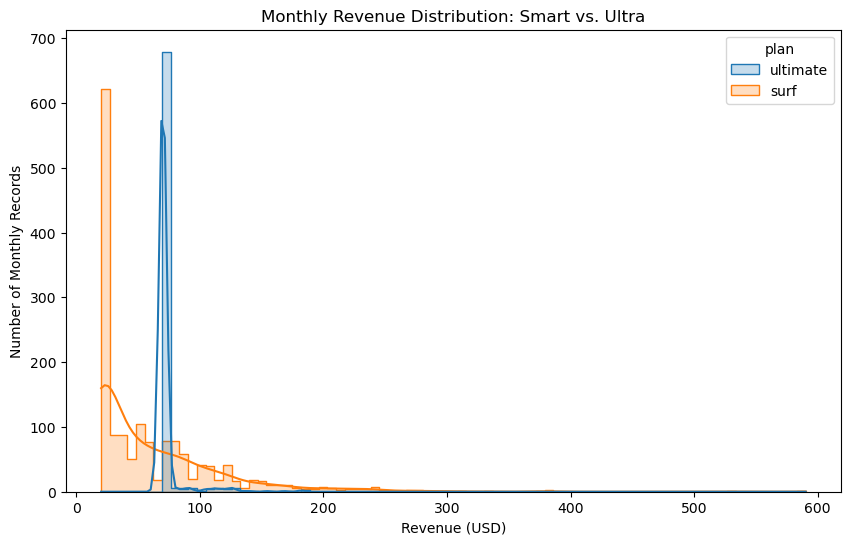

In [387]:
# 1. Comparing Average Monthly Consumption per Plan
plan_comparison = df_final.groupby('plan')[['minutes_total', 'message_count', 'gb_total', 'monthly_revenue']].mean().reset_index()

print("Average Monthly Consumption by Plan:")
display(plan_comparison)

# 2. Visualizing Revenue Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='monthly_revenue', hue='plan', kde=True, element="step")
plt.title('Monthly Revenue Distribution: Smart vs. Ultra')
plt.xlabel('Revenue (USD)')
plt.ylabel('Number of Monthly Records')
plt.show()

### Llamadas

In [388]:
# Comparamos la duración promedio de llamadas por cada plan y por cada mes y trazamos un gráfico de barras para visualizarla.

# creamos una tabla dinámica a partir de la tabla de registros de llamadas
avg_calls_pivot = monthly_data.pivot_table(index='month',
                            columns='plan',
                            values='minutes_total',
                            aggfunc='mean'
                           ).round(2).astype(int) # redondeamos a 2 decimales y tipo entero

print("Consumo promedio de minutos por plan y mes: \n")
print(avg_calls_pivot)

KeyError: 'minutes_total'

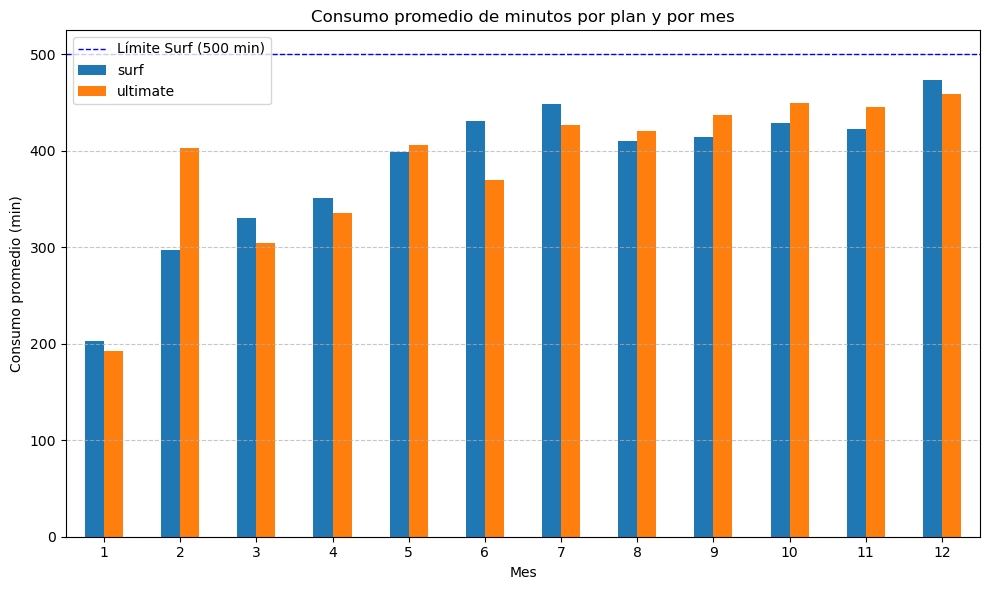

In [ ]:
# graficamos los datos obtenidos
avg_calls_pivot.plot(kind='bar', figsize=(10,6))

plt.title('Consumo promedio de minutos por plan y por mes')
plt.xlabel('Mes')
plt.ylabel('Consumo promedio (min)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# línea de límite del plan surf
# no incluimos la del plan ultimate porque está muy alejada de los valores del gráfico, y afectaría negativamente a nuestra escala
plt.axhline(500, color='blue', linestyle='--', linewidth=1, label='Límite Surf (500 min)')

plt.tight_layout()
plt.legend()
plt.show()

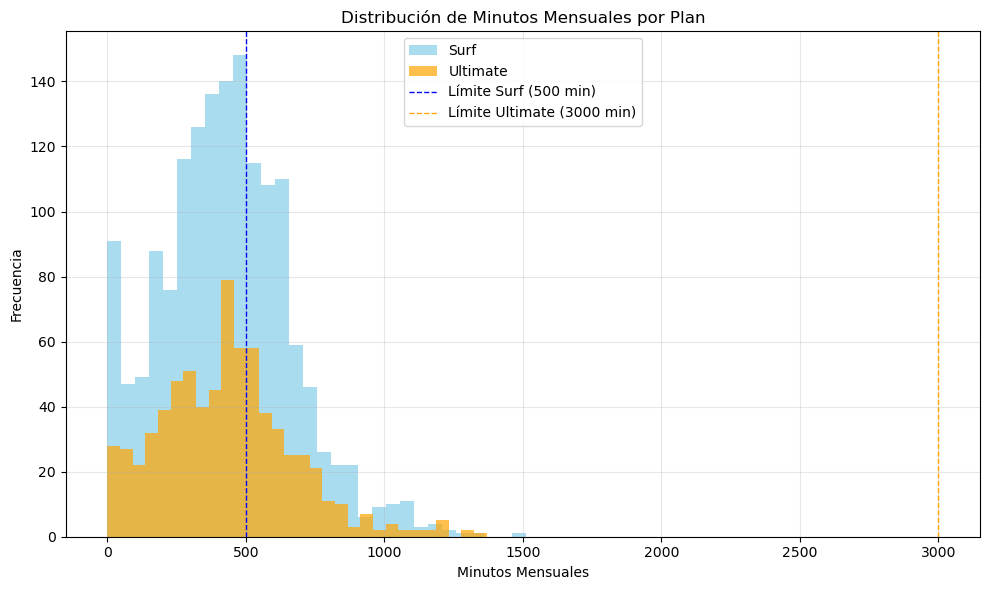

In [ ]:
# Comparamos el número de minutos mensuales que necesitan los usuarios de cada plan y trazamos un histograma.
# como estamos comparando la DISTRIBUCIÓN de los minutos que necesitan los usuarios por mes, pasaremos directo al histograma

# filtramos nuestra tabla principal por plan
surf_users= monthly_data[monthly_data['plan'] == 'surf']
ultimate_users= monthly_data[monthly_data['plan'] == 'ultimate']

# separamos los datos de minutos por plan
surf_minutos = surf_users['minutes_total']
ultimate_minutos = ultimate_users['minutes_total']

# creamos la ventana del gráfico
plt.figure(figsize=(10, 6))

# creamos histogramas superpuestos con transparencia
plt.hist(surf_minutos, bins=30, alpha=0.7, label='Surf', color='skyblue')
plt.hist(ultimate_minutos, bins=30, alpha=0.7, label='Ultimate', color='orange')

# personalizamos el gráfico
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Minutos Mensuales por Plan')
plt.grid(True, alpha=0.3)

# línea de límites de consumo por plan
plt.axvline(500, color='blue', linestyle='--', linewidth=1, label='Límite Surf (500 min)')
plt.axvline(3000, color='orange', linestyle='--', linewidth=1, label='Límite Ultimate (3000 min)')

plt.tight_layout()
plt.legend()
plt.show()

Vemos que no es poco frecuente que los usuarios del plan Surf superen los límites de su plan y, por ende, incurran en gastos extra. Procederemos a averiguar exactamente qué porcentaje de los usuarios de Surf supera dicho límite.

In [ ]:
# Contamos cuántos usuarios de Surf superan los 500 minutos
porcentaje_surf_sobre_limite = (surf_users['minutes_total'] > 500).sum() / len(surf_users) * 100

print(f"{porcentaje_surf_sobre_limite:.2f}% de los usuarios del plan Surf superan los 500 minutos.")

# Contamos cuántos usuarios de Ultimate superan los 3000 minutos
porcentaje_ultimate_sobre_limite = (ultimate_users['minutes_total'] > 3000).sum() / len(ultimate_users) * 100

print(f"{porcentaje_ultimate_sobre_limite:.2f}% de los usuarios del plan Ultimate superan los 3000 minutos.")

35.98% de los usuarios del plan Surf superan los 500 minutos.
0.00% de los usuarios del plan Ultimate superan los 3000 minutos.


Efectivamente, una **gran cantidad de usuarios del plan Surf** incurre en gastos extra por **consumir más minutos** de los incluidos en su plan. Por otro lado, los del **plan Ultimate** jamás superan el límite.

In [ ]:
# Calculamos la media y la varianza de la duración mensual de llamadas.
# utilizamos los datos que ya teníamos separados por plan de la duración mensual de llamadas

# calculamos estadísticas descriptivas para cada plan
print("=== ESTADÍSTICAS DE DURACIÓN MENSUAL DE LLAMADAS ===")

for plan in monthly_data['plan'].unique():
    plan_data = monthly_data[monthly_data['plan'] == plan]['minutes_total']
    print(f"\n=== PLAN {plan.upper()} ===")
    print(f"Media: {plan_data.mean():.2f} minutos")
    print(f"Mediana: {plan_data.median():.2f} minutos")
    print(f"Varianza: {plan_data.var():.2f}")
    print(f"Desviación estándar: {plan_data.std():.2f}")
    print(f"Mínimo: {plan_data.min():.2f} minutos")
    print(f"Máximo: {plan_data.max():.2f} minutos")

print("\n=== COMPARACIÓN ===")
print(f"Diferencia en media: {ultimate_minutos.mean() - surf_minutos.mean():.2f} minutos")
print(f"Ratio de varianzas (Ultimate/Surf): {ultimate_minutos.var() / surf_minutos.var():.2f}")


=== ESTADÍSTICAS DE DURACIÓN MENSUAL DE LLAMADAS ===

=== PLAN ULTIMATE ===
Media: 430.45 minutos
Mediana: 424.00 minutos
Varianza: 57844.46
Desviación estándar: 240.51
Mínimo: 0.00 minutos
Máximo: 1369.00 minutos

=== PLAN SURF ===
Media: 428.75 minutos
Mediana: 425.00 minutos
Varianza: 54968.28
Desviación estándar: 234.45
Mínimo: 0.00 minutos
Máximo: 1510.00 minutos

=== COMPARACIÓN ===
Diferencia en media: 1.70 minutos
Ratio de varianzas (Ultimate/Surf): 1.05


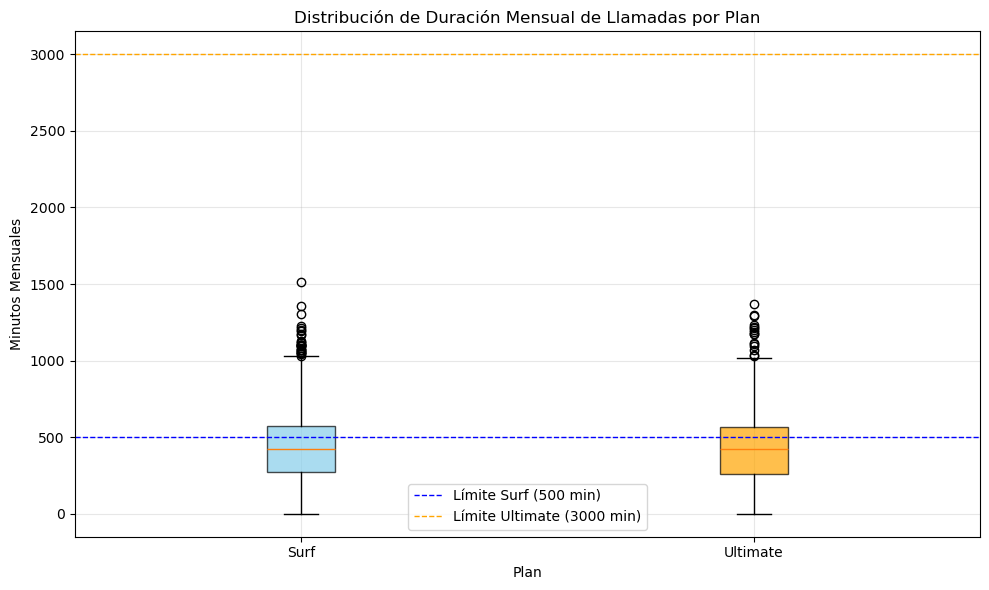

In [ ]:
# Trazamos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

# creamos la ventana del gráfico
plt.figure(figsize=(10, 6))

# creamos boxplot con los datos de ambos planes
data_to_plot = [surf_minutos, ultimate_minutos] # lista con conjuntos de datos
labels = ['Surf', 'Ultimate'] # etiquetas para el eje X

box_plot = plt.boxplot(data_to_plot, tick_labels=labels, patch_artist=True) # patch_artist=True nos permite personalizar los colores de las cajas

# personalizamos los colores
colors = ['skyblue', 'orange'] # lista de colores para cada caja
for patch, color in zip(box_plot['boxes'], colors): # emparejamos cada caja con su color
    patch.set_facecolor(color) # cambiamos el color de relleno
    patch.set_alpha(0.7) # y la transparencia

# personalizamos el gráfico
plt.title('Distribución de Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Minutos Mensuales')
plt.grid(True, alpha=0.3)

# línea de límites de consumo por plan
plt.axhline(500, color='blue', linestyle='--', linewidth=1, label='Límite Surf (500 min)')
plt.axhline(3000, color='orange', linestyle='--', linewidth=1, label='Límite Ultimate (3000 min)')

plt.tight_layout()
plt.legend()
plt.show()

## Conclusiones sobre el comportamiento de los usuarios respecto a las llamadas:

- **Tendencia estable y comportamiento consistente durante el año.**

Los promedios mensuales muestran una **evolución notable:** ambos planes crecen desde **~200 min a inicios del año** hasta unos **~450 min hacia fin de año.**
Esto sugiere un aumento gradual del uso, más evidente en los primeros 5 meses del año. De todas formas, el comportamiento no varía significativamente dependiendo del plan, sino que los usuarios de los **planes Surf y Ultimate hablan prácticamente lo mismo** cada mes, excepto en el mes 2 que se observa una diferencia de aprox 100 minutos.

- **Distribución similar, pero con más usuarios en Surf:**

  El histograma muestra que la **mayoría** de los usuarios de **ambos planes** consumen **entre 400 y 800 minutos mensuales**, aunque el plan **Surf** presenta una **distribución más amplia**: hay usuarios que hablan muchísimo más y otros que casi no usan minutos.

  Esto puede deberse a que el plan Surf es más económico y atrae **perfiles de consumo más diversos.**

- **Usuarios del plan Surf superan parcialmente el límite:**
  El plan Surf incluye 500 minutos mensuales, y la media de consumo (≈429 min) está por debajo del límite. Sin embargo, un **35,98% de los usuarios supera** los 500 minutos, lo que indica que **un grupo significativo sí paga minutos extra.**

  Por otro lado, con 3000 minutos disponibles, el **plan Ultimate** tiene un margen muy amplio, y **ningún usuario lo supera**, lo que confirma que el límite es más que suficiente para el consumo promedio.

- **Estadísticas descriptivas prácticamente idénticas:**

  - **Media:** Surf 428.75 minutos vs Ultimate 430.45 minutos→ diferencia de apenas 1.7 min.

  - **Desviación estándar:** Surf 234.45 minutos vs Ultimate 240.51 minutos → variabilidad similar. Es alta en ambos planes, lo que muestra que hay usuarios que utilizan muy pocos minutos (o ninguno) y otros que utilizan cientos.

  - **Varianzas prácticamente iguales** (ratio ≈ 1) → las dispersiones son casi idénticas.

  Esto confirma que *el consumo típico de minutos no está influenciado por el tipo de plan.*

  - **Boxplot: sin diferencias notables en la mediana ni en la dispersión:**
  Ambos planes muestran una mediana similar (~425 min) y una distribución con pocos outliers, indicando comportamientos de uso consistentes.

### Conclusión general

El tipo de **plan no influye** significativamente en la **cantidad de minutos** usados mensualmente.

En el plan **Surf**, aunque la **media** de consumo está por **debajo del límit**e (≈429 min), aproximadamente el **36%** de los usuarios **supera** los 500 minutos, generando **ingresos adicionales** por minutos excedentes.

En el plan **Ultimate, ningún usuario supera** los 3000 minutos, por lo que los ingresos por excedentes son inexistentes.

En otras palabras: Los *ingresos por llamadas excedentes solo son relevantes en Surf*, y no justifican por sí solos la diferencia de precio entre planes.

La diferencia de precio probablemente se explica más por datos móviles y mensajes, que conviene analizar a continuación.

### Mensajes

In [ ]:
# comparamos el consumo promedio de mensajes por cada plan y por cada mes y trazamos un gráfico de barras para visualizarlo
# Creamos una pivot table para promedio de mensajes por usuario, por plan y mes
avg_messages_pivot = monthly_data.pivot_table(
    index='month',
    columns='plan',
    values='message_count',
    aggfunc='mean'
).round().astype(int)

print("Promedio de mensajes por plan y mes:\n")
print(avg_messages_pivot)

Promedio de mensajes por plan y mes:

plan   surf  ultimate
month                
1        10        16
2        12        22
3        15        20
4        17        22
5        24        32
6        25        29
7        27        33
8        29        38
9        31        38
10       34        39
11       32        39
12       39        45


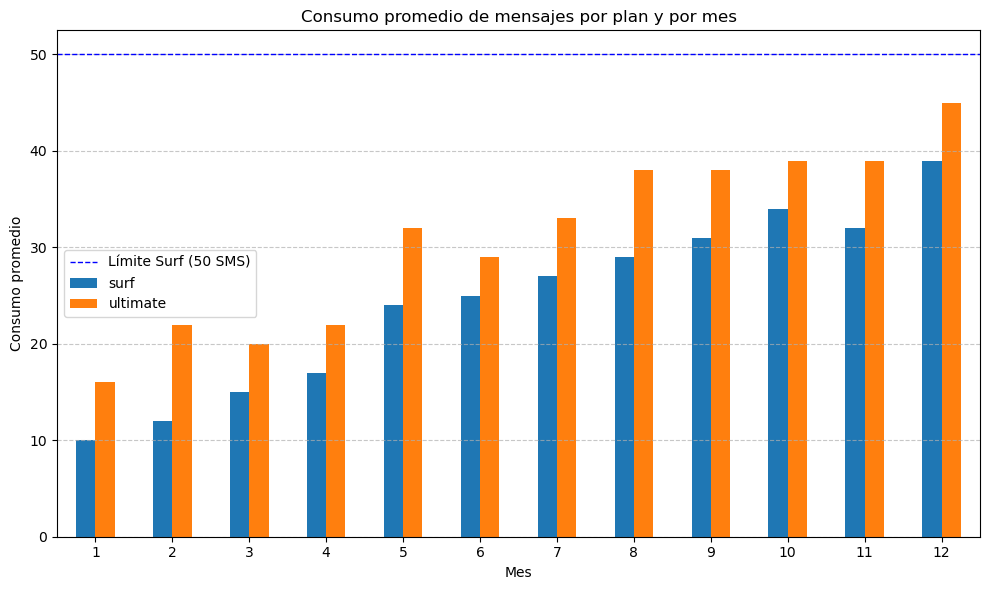

In [ ]:
# graficamos los datos obtenidos
avg_messages_pivot.plot(kind='bar', figsize=(10,6))

plt.title('Consumo promedio de mensajes por plan y por mes')
plt.xlabel('Mes')
plt.ylabel('Consumo promedio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# línea de límite del plan surf
# no incluimos la del plan ultimate porque está muy alejada de los valores del gráfico, y afectaría negativamente a nuestra escala
plt.axhline(50, color='blue', linestyle='--', linewidth=1, label='Límite Surf (50 SMS)')

plt.legend()
plt.tight_layout()
plt.show()

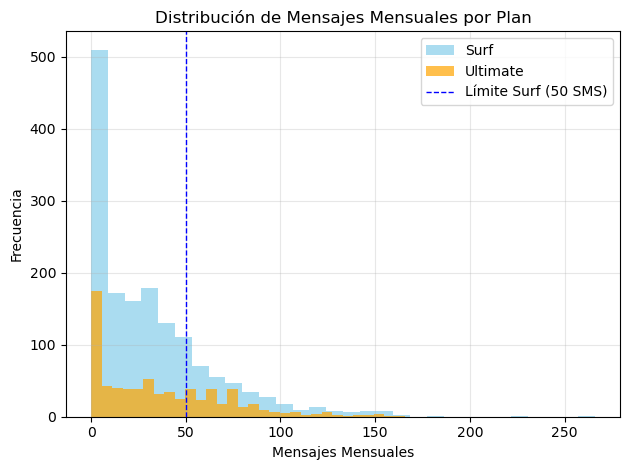

In [ ]:
# Compraramos el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
# separamos los datos por plan
surf_messages = surf_users['message_count']
ultimate_messages = ultimate_users['message_count']

# creamos histogramas superpuestos con transparencia
plt.hist(surf_messages, bins=30, alpha=0.7, label='Surf', color='skyblue')
plt.hist(ultimate_messages, bins=30, alpha=0.7, label='Ultimate', color='orange')

# personalizamos el gráfico
plt.xlabel('Mensajes Mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Mensajes Mensuales por Plan')
plt.grid(True, alpha=0.3)

# líneas de límite del plan surf
# no incluimos la del plan ultimate porque está muy alejada de los valores del gráfico, y afectaría negativamente a nuestra escala
plt.axvline(50, color='blue', linestyle='--', linewidth=1, label='Límite Surf (50 SMS)')

plt.legend()
plt.tight_layout()
plt.show()


También en este caso vemos que no es poco frecuente que los usuarios de Surf superen su límite de consumo mensual. Veamos en qué porcentaje:

In [ ]:
# Contamos cuántos superan los 50 mensajes en el plan surf
porcentaje_surf_sobre_limite_msg = (surf_messages > 50).sum() / len(surf_users) * 100

print(f"{porcentaje_surf_sobre_limite_msg:.2f}% de los usuarios del plan Surf superan los 50 mensajes.")


# Contamos cuántos superan los 1000 mensajes en el plan ultimate
porcentaje_ultimate_sobre_limite_msg = (ultimate_messages > 1000).sum() / len(ultimate_users) * 100

print(f"{porcentaje_ultimate_sobre_limite_msg:.2f}% de los usuarios del plan Ultimate superan los 1000 mensajes.")

21.61% de los usuarios del plan Surf superan los 50 mensajes.
0.00% de los usuarios del plan Ultimate superan los 1000 mensajes.


Efectivamente, no es un porcentaje despreciable. **Un 21,61% de los usuarios del plan Surf supera su consumo mensual.**

In [ ]:
# calculamos la media y la varianza del consumo mensual de mensajes.
# como ya teníamos los datos separados por plan, procedemos a analizarlos

# calculamos estadísticas descriptivas para cada plan
print("=== ESTADÍSTICAS DE CONSUMO DE MENSAJES ===\n")

for plan in monthly_data['plan'].unique():
    plan_data = monthly_data[monthly_data['plan'] == plan]['message_count']
    print(f"\n=== PLAN {plan.upper()} ===")
    print(f"Media: {plan_data.mean():.2f} mensajes")
    print(f"Mediana: {plan_data.median():.2f} mensajes")
    print(f"Varianza: {plan_data.var():.2f}")
    print(f"Desviación estándar: {plan_data.std():.2f}")
    print(f"Mínimo: {plan_data.min():.2f} mensajes")
    print(f"Máximo: {plan_data.max():.2f} mensajes")

print("\n=== COMPARACIÓN ===")
print(f"Diferencia en media: {ultimate_messages.mean() - surf_messages.mean():.2f} mensajes")
print(f"Ratio de varianzas (Ultimate/Surf): {ultimate_messages.var() / surf_messages.var():.2f}")



=== ESTADÍSTICAS DE CONSUMO DE MENSAJES ===


=== PLAN ULTIMATE ===
Media: 37.55 mensajes
Mediana: 30.00 mensajes
Varianza: 1208.76
Desviación estándar: 34.77
Mínimo: 0.00 mensajes
Máximo: 166.00 mensajes

=== PLAN SURF ===
Media: 31.16 mensajes
Mediana: 24.00 mensajes
Varianza: 1126.72
Desviación estándar: 33.57
Mínimo: 0.00 mensajes
Máximo: 266.00 mensajes

=== COMPARACIÓN ===
Diferencia en media: 6.39 mensajes
Ratio de varianzas (Ultimate/Surf): 1.07


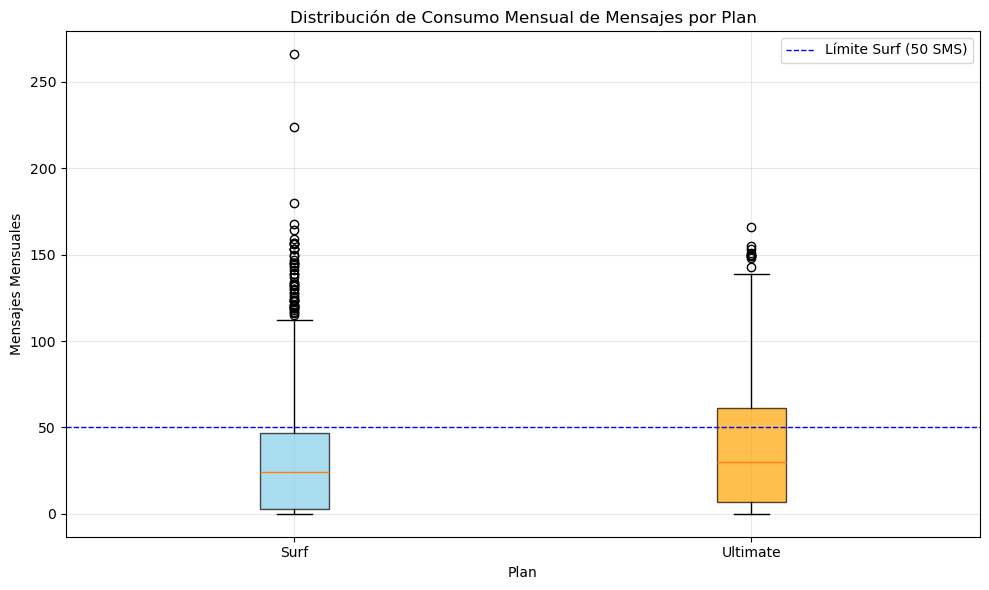

In [ ]:
# trazamos un diagrama de caja para visualizar la distribución del consumo mensual de mensajes
# creamos la ventana del gráfico
plt.figure(figsize=(10, 6))

# creamos boxplot con los datos de ambos planes
data_to_plot = [surf_messages, ultimate_messages] # lista con conjuntos de datos
labels = ['Surf', 'Ultimate'] # etiquetas para el eje X

box_plot = plt.boxplot(data_to_plot, tick_labels= labels, patch_artist=True) # patch_artist=True nos permite personalizar los colores de las cajas

# personalizamos los colores
colors = ['skyblue', 'orange'] # lista de colores para cada caja
for patch, color in zip(box_plot['boxes'], colors): # emparejamos cada caja con su color
    patch.set_facecolor(color) # cambiamos el color de relleno
    patch.set_alpha(0.7) # y la transparencia

# personalizamos el gráfico
plt.title('Distribución de Consumo Mensual de Mensajes por Plan')
plt.xlabel('Plan')
plt.ylabel('Mensajes Mensuales')
plt.grid(True, alpha=0.3)

# líneas de límite del plan surf
# no incluimos la del plan ultimate porque está muy alejada de los valores del gráfico, y afectaría negativamente a nuestra escala
plt.axhline(50, color='blue', linestyle='--', linewidth=1, label='Límite Surf (50 SMS)')

plt.legend()
plt.tight_layout()
plt.show()

## Conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes

- **Tendencia general al alza durante el año:**

  El **consumo promedio** de mensajes **aumenta gradualmente durante el año** en **ambos planes**, lo que indica un uso más intensivo del servicio hacia fin de año.

  - En **enero**, los usuarios enviaban en **promedio 10 (Surf) y 16 (Ultimate)SMS.**
  - En **diciembre**, el promedio subió a **39 (Surf) y 45 (Ultimate)**.

- **Diferencias claras entre planes:**

  Los usuarios del **plan Ultimate** envían sistemáticamente **más mensajes** que los del **plan Surf.**

  La **diferencia promedio** es de **~6 mensajes mensuales**, pero lo más relevante es que **Ultimate** tiene **límites mucho más altos (1000 SMS)** frente a solo 50 SMS en Surf.

  Observación clave: solo **21,61%** de los **usuarios de Surf supera su límite**, mientras que **ningún usuario de Ultimate lo hace.** Esto indica que los **ingresos por excedentes** solo son **relevantes para Surf** y que Ultimate tiene un margen muy amplio.
  
- **Distribución y dispersión:**

  La **desviación estándar es alta en ambos planes (~34 mensajes)**, lo que muestra que hay usuarios que mandan poquísimos mensajes (o ninguno) y otros que mandan cientos.

  En el boxplot se ve claramente una **gran cantidad de outliers** por encima del límite del **plan Surf**, lo que refuerza la idea de que, al ser un plan más económico, atrae perfiles de consumo muy diversos.

## Conclusión estratégica:
El **comportamiento** de los usuarios sí **varía** según el plan.

Los usuarios del **plan Surf** tienden a **subestimar su consumo** real de SMS, por lo que podrían ser **buenos candidatos para un upgrade** al plan Ultimate.

En cambio, los del **plan Ultimate** están **muy por debajo de su límite**, lo cual sugiere que ese plan podría estar **sobrevaluado para su uso típico** (pagan más por recursos que no usan).

### Internet

In [ ]:
# Comparamos la cantidad de tráfico de Internet (GB) consumido por usuarios por plan
# creamos una pivot table para promedio de GB por usuario, por plan y mes
avg_gb_pivot = monthly_data.pivot_table(
    index='month',
    columns='plan',
    values='gb_total',
    aggfunc='mean'
).round().astype(int)

print("Promedio de consumo de internet (GB) por plan y mes:\n")
print(avg_gb_pivot)

Promedio de consumo de internet (GB) por plan y mes:

plan   surf  ultimate
month                
1         5         7
2        12        17
3        14        18
4        12        16
5        14        17
6        15        15
7        17        16
8        17        18
9        17        17
10       17        18
11       16        17
12       18        18


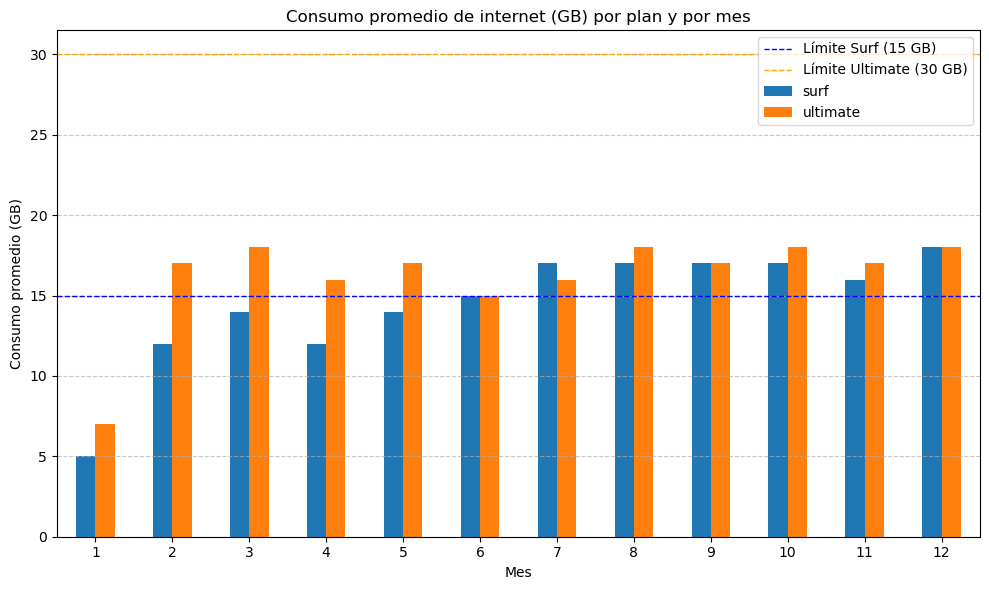

In [ ]:
# graficamos los datos obtenidos
avg_gb_pivot.plot(kind='bar', figsize=(10,6))

plt.title('Consumo promedio de internet (GB) por plan y por mes')
plt.xlabel('Mes')
plt.ylabel('Consumo promedio (GB)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# línea de límite del plan surf
# no incluimos la del plan ultimate porque está muy alejada de los valores del gráfico, y afectaría negativamente a nuestra escala
plt.axhline(15, color='blue', linestyle='--', linewidth=1, label='Límite Surf (15 GB)')
plt.axhline(30, color='orange', linestyle='--', linewidth=1, label='Límite Ultimate (30 GB)')

plt.legend()
plt.tight_layout()
plt.show()

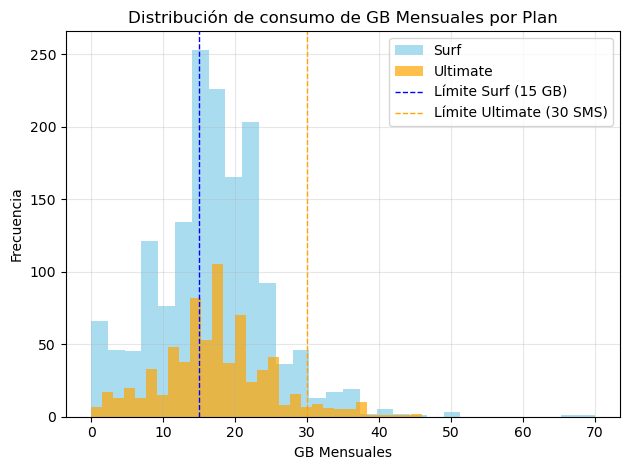

In [ ]:
# Compraramos el número de GB que tienden a utilizar cada mes los usuarios de cada plan
# separamos los datos por plan
surf_internet = surf_users['gb_total']
ultimate_internet = ultimate_users['gb_total']

# creamos histogramas superpuestos con transparencia
plt.hist(surf_internet, bins=30, alpha=0.7, label='Surf', color='skyblue')
plt.hist(ultimate_internet, bins=30, alpha=0.7, label='Ultimate', color='orange')

# personalizamos el gráfico
plt.xlabel('GB Mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de consumo de GB Mensuales por Plan')
plt.grid(True, alpha=0.3)

# incluimos líneas de límite de internet de cada plan
plt.axvline(15, color='blue', linestyle='--', linewidth=1, label='Límite Surf (15 GB)')
plt.axvline(30, color='orange', linestyle='--', linewidth=1, label='Límite Ultimate (30 SMS)')

plt.legend()
plt.tight_layout()
plt.show()


En este caso, a diferencia de los anteriores, vemos que en ambos planes se supera su límite, siendo en el caso de Surf la mayor cantidad observada. Veamos exactamente qué porcentaje:

In [ ]:
# Contamos qué porcentaje supera los 15 GB en el plan surf
porcentaje_surf_sobre_limite_gb = (surf_internet > 15).sum() / len(surf_users) * 100

print(f"{porcentaje_surf_sobre_limite_gb:.2f}% de los usuarios del plan Surf superan los 15 GB. \n")

# Contamos qué porcentaje supera los 30 GB en el plan surf (potencial upgrade a ultimate)
porcentaje_surf_sobre_limite_gb2 = (surf_internet > 30).sum() / len(surf_users) * 100

print(f"{porcentaje_surf_sobre_limite_gb2:.2f}% de los usuarios del plan Surf superan los 30 GB. \n")

# Contamos qué porcentaje supera los 30 GB en el plan ultimate
porcentaje_ultimate_sobre_limite_gb = (ultimate_internet > 30).sum() / len(ultimate_users) * 100

print(f"{porcentaje_ultimate_sobre_limite_gb:.2f}% de los usuarios del plan Ultimate superan los 30 GB.")

57.91% de los usuarios del plan Surf superan los 15 GB. 

4.07% de los usuarios del plan Surf superan los 30 GB. 

5.69% de los usuarios del plan Ultimate superan los 30 GB.


In [ ]:
# calculamos la media y la varianza del consumo mensual de internet

# calculamos estadísticas descriptivas para cada plan
print("=== ESTADÍSTICAS DE CONSUMO DE INTERNET (GB) ===\n")

for plan in monthly_data['plan'].unique():
    plan_data = monthly_data[monthly_data['plan'] == plan]['gb_total']
    print(f"\n=== PLAN {plan.upper()} ===")
    print(f"Media: {plan_data.mean():.2f} gb")
    print(f"Mediana: {plan_data.median():.2f} gb")
    print(f"Varianza: {plan_data.var():.2f}")
    print(f"Desviación estándar: {plan_data.std():.2f}")
    print(f"Mínimo: {plan_data.min():.2f} gb")
    print(f"Máximo: {plan_data.max():.2f} gb")

print("\n=== COMPARACIÓN ===")
print(f"Diferencia en media: {ultimate_internet.mean() - surf_internet.mean():.2f} gb")
print(f"Ratio de varianzas (Ultimate/Surf): {ultimate_internet.var() / surf_internet.var():.2f}")

=== ESTADÍSTICAS DE CONSUMO DE INTERNET (GB) ===


=== PLAN ULTIMATE ===
Media: 17.31 gb
Mediana: 17.00 gb
Varianza: 58.83
Desviación estándar: 7.67
Mínimo: 0.00 gb
Máximo: 46.00 gb

=== PLAN SURF ===
Media: 16.67 gb
Mediana: 17.00 gb
Varianza: 61.58
Desviación estándar: 7.85
Mínimo: 0.00 gb
Máximo: 70.00 gb

=== COMPARACIÓN ===
Diferencia en media: 0.64 gb
Ratio de varianzas (Ultimate/Surf): 0.96


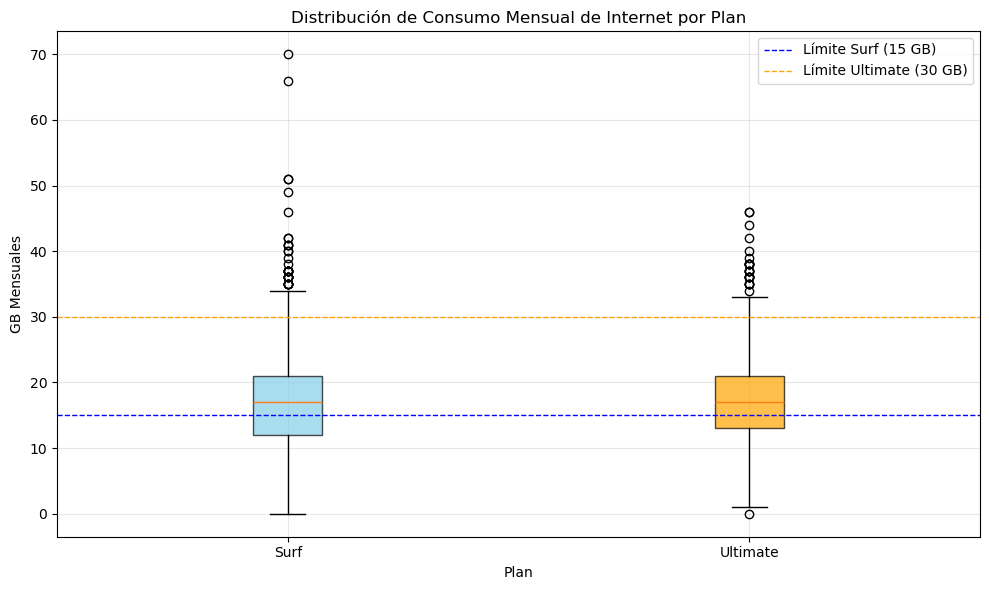

In [ ]:
# trazamos un diagrama de caja para visualizar la distribución del consumo mensual de internet (gb)
# creamos la ventana del gráfico
plt.figure(figsize=(10, 6))

# creamos boxplot con los datos de ambos planes
data_to_plot = [surf_internet, ultimate_internet] # lista con conjuntos de datos
labels = ['Surf', 'Ultimate'] # etiquetas para el eje X

box_plot = plt.boxplot(data_to_plot, tick_labels= labels, patch_artist=True) # patch_artist=True nos permite personalizar los colores de las cajas

# personalizamos los colores
colors = ['skyblue', 'orange'] # lista de colores para cada caja
for patch, color in zip(box_plot['boxes'], colors): # emparejamos cada caja con su color
    patch.set_facecolor(color) # cambiamos el color de relleno
    patch.set_alpha(0.7) # y la transparencia

# personalizamos el gráfico
plt.title('Distribución de Consumo Mensual de Internet por Plan')
plt.xlabel('Plan')
plt.ylabel('GB Mensuales')
plt.grid(True, alpha=0.3)

# líneas de límite del plan surf
plt.axhline(15, color='blue', linestyle='--', linewidth=1, label='Límite Surf (15 GB)')
plt.axhline(30, color='orange', linestyle='--', linewidth=1, label='Límite Ultimate (30 GB)')

plt.legend()
plt.tight_layout()
plt.show()

## Conclusiones sobre el comportamiento de los usuarios respecto al uso de Internet

1. **Consumo promedio similar entre planes, pero con diferencias en los extremos.**

El **promedio mensual es prácticamente igual** (16.7 GB en Surf y 17.3 GB en Ultimate), con mediana de 17 GB y una **dispersión parecida** (desvío estándar ≈ 7.7 GB).

Sin embargo, en el plan **Surf** se observan **outliers marcados**, con usuarios que alcanzan consumos de **hasta 70 GB**, mientras que en Ultimate los valores extremos no superan los 50 GB.

Esto indica que, **aunque el uso típico es similar, el Surf concentra a los usuarios de consumo más alto.**

2. **Alta proporción de usuarios de Surf supera su límite.**

**El 57.9 % de los usuarios de Surf supera los 15 GB incluidos**, y un **4 %** incluso **sobrepasa los 30 GB**, lo que significa que más de la mitad incurre en costos adicionales por extra GB.

Esto convierte al uso de **Internet** en la **principal fuente de ingresos variables del plan Surf.**

En cambio, en el plan **Ultimate** solo el **5.7 % supera su límite de 30 GB**, lo que muestra que la mayoría paga por capacidad que no utiliza.

3. **Distribución concentrada y consistente.**

El histograma muestra que el consumo de **Surf** tiene una **cola derecha pronunciada** (usuarios que superan los 15 GB) y una **mayor densidad** justo **en torno al límite**, lo cual confirma el patrón de sobreuso.

**Ultimate** presenta una **distribución más estable**, centrada **entre 15 y 20 GB**, sin valores extremos significativos.

4. **Evolución estable a lo largo del año.**

Ambos planes muestran un **crecimiento inicial** (enero-mayo) y luego un **consumo estable** alrededor de 17-18 GB mensuales, lo que sugiere que el uso de Internet se mantiene constante y **no presenta estacionalidad marcada**.


## Conclusión parcial

Aunque el **consumo promedio** de Internet es **similar**, el **comportamiento** de los usuarios **varía** claramente según el plan.

**Surf** tiene una base más **heterogénea**, con usuarios que **exceden con frecuencia los límites**, generando **mayor rentabilidad por cargos extra**, mientras que **Ultimate** agrupa a usuarios de **consumo estable y sin excedentes**, lo que implica **menor rentabilidad por uso efectivo**.

## Ingreso

In [ ]:
# con un bucle for filtramos la tabla de monthly_data para cada plan
# agrupamos la tabla filtrada por mes y sumamos los ingresos mensuales
# averiguamos valores estadísticos relevantes
print("Descripción Estadística de los ingresos totales por plan por mes: \n")
for plan in monthly_data['plan'].unique():
    plan_data = monthly_data[monthly_data['plan'] == plan].groupby('month')['monthly_earnings'].sum()
    print(f"\n=== PLAN {plan.upper()} ===")
    print(f"Media: ${plan_data.mean():.2f}")
    print(f"Mediana: ${plan_data.median():.2f}")
    print(f"Varianza: {plan_data.var():.2f}")
    print(f"Desviación estándar: {plan_data.std():.2f}")
    print(f"Mínimo: ${plan_data.min():.2f}")
    print(f"Máximo: ${plan_data.max():.2f}")

Descripción Estadística de los ingresos totales por plan por mes: 


=== PLAN ULTIMATE ===
Media: $4338.83
Mediana: $3804.50
Varianza: 12764516.33
Desviación estándar: 3572.75
Mínimo: $280.00
Máximo: $11067.00

=== PLAN SURF ===
Media: $7957.60
Mediana: $6181.68
Varianza: 53420670.29
Desviación estándar: 7308.94
Mínimo: $40.00
Máximo: $22437.14


Con los datos obtenidos podemos visualizar:
- Qué plan genera **más ingresos promedio**
- Qué tan **dispersos** son esos ingresos (varianza alta = más usuarios pagando extra)
- Si hay **outliers** (usuarios con gastos inusualmente altos)

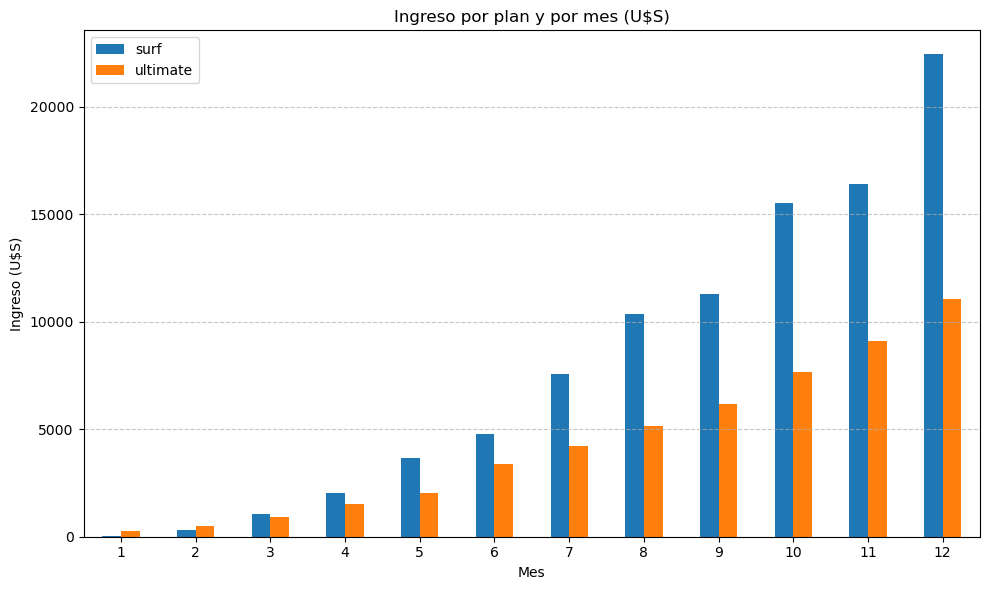

In [ ]:
# realizamos un gráfico de barras del ingreso mensual por plan y por mes
monthly_earnings = monthly_data.groupby(['month', 'plan'])['monthly_earnings'].sum().unstack()
monthly_earnings.plot(kind='bar', figsize=(10,6))

plt.title('Ingreso por plan y por mes (U$S)')
plt.xlabel('Mes')
plt.ylabel('Ingreso (U$S)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

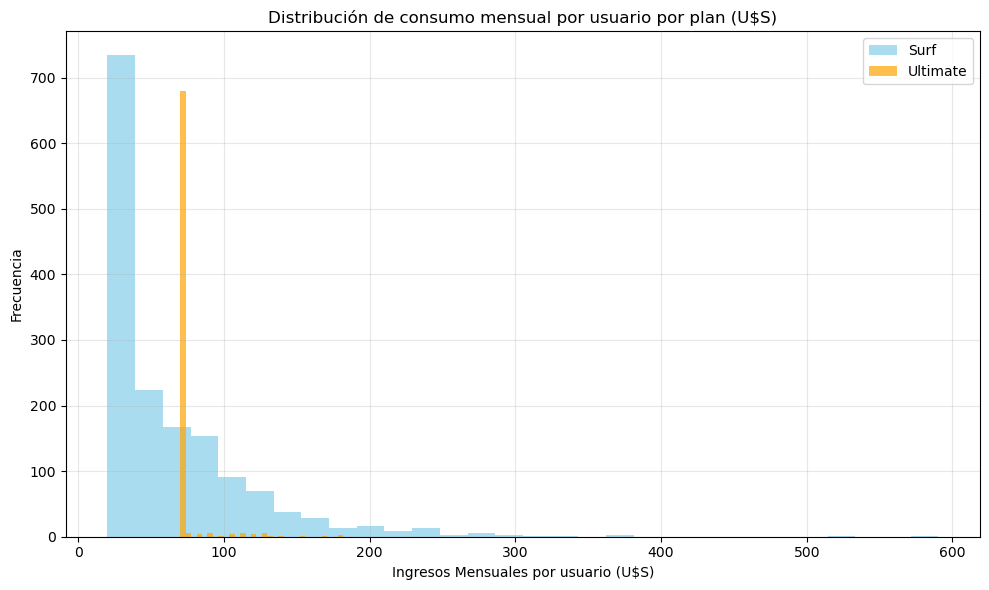

In [ ]:
# compraramos los ingresos que tienden a registrarse por usuario, cada mes por cada plan
# separamos los datos por plan
surf_earnings = surf_users['monthly_earnings']
ultimate_earnings = ultimate_users['monthly_earnings']

# creamos histogramas superpuestos con transparencia
plt.figure(figsize=(10, 6))
plt.hist(surf_earnings, bins=30, alpha=0.7, label='Surf', color='skyblue')
plt.hist(ultimate_earnings, bins=30, alpha=0.7, label='Ultimate', color='orange')

# personalizamos el gráfico
plt.xlabel('Ingresos Mensuales por usuario (U$S)')
plt.ylabel('Frecuencia')
plt.title('Distribución de consumo mensual por usuario por plan (U$S)')
plt.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

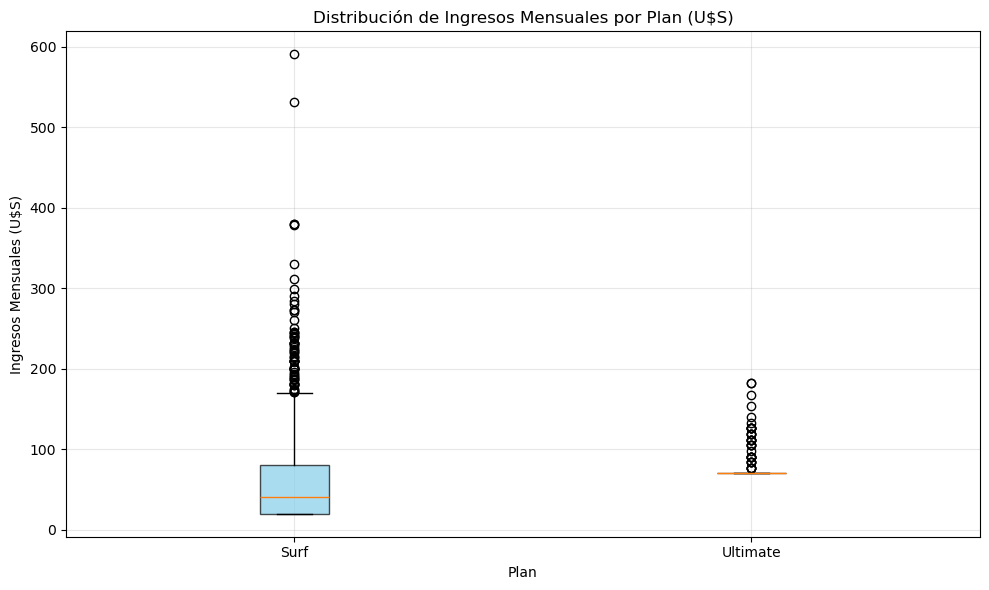

In [ ]:
# creamos un Boxplot de ingresos mensuales por plan
# creamos la ventana del gráfico
plt.figure(figsize=(10, 6))

# creamos boxplot con los datos de ambos planes
data_to_plot = [surf_earnings, ultimate_earnings] # lista con conjuntos de datos
labels = ['Surf', 'Ultimate'] # etiquetas para el eje X

box_plot = plt.boxplot(data_to_plot, tick_labels= labels, patch_artist=True) # patch_artist=True nos permite personalizar los colores de las cajas

# personalizamos los colores
colors = ['skyblue', 'orange'] # lista de colores para cada caja
for patch, color in zip(box_plot['boxes'], colors): # emparejamos cada caja con su color
    patch.set_facecolor(color) # cambiamos el color de relleno
    patch.set_alpha(0.7) # y la transparencia

# personalizamos el gráfico
plt.title('Distribución de Ingresos Mensuales por Plan (U$S)')
plt.xlabel('Plan')
plt.ylabel('Ingresos Mensuales (U$S)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusiones sobre los ingresos de los planes

1. **Ingresos promedio muy distintos entre planes.**

El plan **Surf** genera en **promedio 7957.60 por mes**, casi el **doble** que **Ultimate (4338.83).**

Esto demuestra que, aunque **Surf** tiene una **tarifa base más baja**, su estructura de cobros por **excedentes** (minutos, SMS y GB) hace que sus **ingresos totales sean mucho más altos y variables.**

2. **Surf: plan más rentable pero con alta dispersión.**

**La desviación estándar en Surf (7308.94) es el doble que en Ultimate**, lo que refleja **gran variabilidad** entre usuarios.

El rango va desde 40 hasta más de 22 000, con **outliers marcados** que representan **clientes de alto consumo.**

Esto confirma que **Surf** obtiene **ganancias significativas por usuarios que superan frecuentemente sus límites**, especialmente en Internet.

3. **Ultimate: ingresos más estables y previsibles.**

En **Ultimate**, los **ingresos** están más **concentrados** alrededor de la **media** ($4339) y con **menor dispersión.**

Su rango (de $280 a $11 067) indica **menos extremos y un comportamiento más uniforme**: *la mayoría de los usuarios paga el monto base sin excedentes.*

4. **Gráficamente, la diferencia es clara.**

El gráfico de barras muestra que **Surf supera consistentemente a Ultimate en ingresos mensuales totales.**

El histograma y el boxplot evidencian que **Surf tiene una distribución más extendida y asimétrica**, con varios usuarios generando ingresos muy superiores al promedio.

**Ultimate**, en cambio, se mantiene **más compacto**, alrededor del precio base de su plan.

## Conclusión parcial

El análisis muestra que **el plan Surf es el más rentable**, no por su precio base, sino por los **cargos variables** derivados del sobreconsumo, especialmente en datos.

El **plan Ultimate**, aunque más caro, tiene usuarios con un **consumo más contenido**, lo que lo vuelve **menos rentable** por unidad de uso.

En resumen:

- `Surf = alta rentabilidad + alta variabilidad.`

- `Ultimate = ingresos estables + baja rentabilidad marginal.`

## Prueba de hipótesis estadísticas

- Hipótesis nula: "Los **ingresos promedio** procedentes de los usuarios de los planes de llamada Ultimate y Surf son **iguales**."

- Hipótesis alternativa: "Los **ingresos promedio** procedentes de los usuarios de los planes de llamada Ultimate y Surf **difieren**."

- Prueba estadística: "Prueba t bilateral de dos muestras independientes", ya que de esta forma averiguamos la probabilidad de que la diferencia que se observa entre las medias de dos poblaciones sea casualidad o efectivamente pueda significar una diferencia significativa entre ellas.

- Valor alfa: 0.05

In [ ]:
# Prueba las hipótesis

In [ ]:
# antes de realizar la prueba, averiguamos la media de ambas poblaciones y sus desviaciones estándar, para tener una idea de su distribución
print(f"Usuarios Surf: {len(surf_earnings)}\n")
print(f"Usuarios Ultimate: {len(ultimate_earnings)}\n")

print("Estadísticas descriptivas:\n")
print(f"Surf - Media: ${surf_earnings.mean():.2f}, Desv. estándar: ${surf_earnings.std():.2f}\n")
print(f"Ultimate - Media: ${ultimate_earnings.mean():.2f}, Desv. estándar: ${ultimate_earnings.std():.2f}\n")

Usuarios Surf: 1573

Usuarios Ultimate: 720

Estadísticas descriptivas:

Surf - Media: $60.71, Desv. estándar: $55.39

Ultimate - Media: $72.31, Desv. estándar: $11.40



- Confirmamos que las muestras son los suficientemente grandes para realizar una prueba t
- Vemos que las desviaciones estándar son muy distinta, por lo que es razonable asumir varianzas distintas para la prueba t.(equal_var= False)

In [ ]:
# realizamos una prueba t de dos muestras independientes
alpha = 0.05
results = st.ttest_ind(surf_earnings, ultimate_earnings, equal_var= False)
p_igualdad = results.pvalue

print('p-valor:', results.pvalue)

if p_igualdad < alpha:
  print("Rechazamos la hipótesis nula, los ingresos promedio por plan sí difieren.")
else:
  print("No podemos rechazar la hipótesis nula ya que no hay evidencia suficiente de que los ingresos promedio difieran.")

p-valor: 3.1703905481135738e-15
Rechazamos la hipótesis nula, los ingresos promedio por plan sí difieren.


p-valor = 3.17 × 10⁻¹⁵, muchísimo menor que alpha = 0.05

➡️ rechazamos la hipótesis nula

Esto significa que existe evidencia estadísticamente significativa de que los ingresos promedio de los planes Surf y Ultimate son diferentes.

- Hipótesis nula: "El **ingreso promedio** de los usuarios del **área NY-NJ** es **igual** al de los usuarios de **otras regiones**."

- Hipótesis alternativa: "El **ingreso promedio** de los usuarios del **área NY-NJ** es **diferente** al de los usuarios de **otras regiones**."

- Prueba estadística: "Prueba t bilateral de dos muestras independientes", ya que de esta forma averiguamos la probabilidad de que la diferencia que se observa entre las medias de dos poblaciones sea casualidad o efectivamente pueda significar una diferencia significativa entre ellas.

- Valor alfa: 0.05

In [ ]:
# Prueba las hipótesis
# preparamos los datos
# separamos los ingresos por región
ingresos_ny_nj = monthly_data[monthly_data['region'] == 'NY-NJ']['monthly_earnings']
ingresos_otras = monthly_data[monthly_data['region'] == 'Otras']['monthly_earnings']

# antes de realizar la prueba, averiguamos la media de ambas poblaciones y sus desviaciones estándar, para tener una idea de su distribución
print(f"Usuarios NY-NJ: {len(ingresos_ny_nj)}\n")
print(f"Usuarios de otras regiones: {len(ingresos_otras)}\n")

print("Estadísticas descriptivas:\n")
print(f"NY-NJ - Media: ${ingresos_ny_nj.mean():.2f}, Desv. estándar: ${ingresos_ny_nj.std():.2f}\n")
print(f"Otras - Media: ${ingresos_otras.mean():.2f}, Desv. estándar: ${ingresos_otras.std():.2f}\n")

Usuarios NY-NJ: 488

Usuarios de otras regiones: 1805

Estadísticas descriptivas:

NY-NJ - Media: $61.36, Desv. estándar: $45.94

Otras - Media: $65.16, Desv. estándar: $46.79



- Confirmamos que las muestras son los suficientemente grandes para realizar una prueba t
- Las desviaciones estándar son muy similares, por lo que es razonable asumir varianzas iguales para la prueba t.

In [ ]:
# realizamos una prueba t de dos muestras independientes
alpha = 0.05
results = st.ttest_ind(ingresos_ny_nj, ingresos_otras)
p_igualdad = results.pvalue

print('p-valor:', results.pvalue)

if p_igualdad < alpha:
  print("Rechazamos la hipótesis nula, los ingresos promedio por plan sí difieren entre el área NY-NJ y otras regiones.")
else:
  print("No podemos rechazar la hipótesis nula ya que no hay evidencia suficiente de que los ingresos promedio difieran.")

p-valor: 0.11013307329186472
No podemos rechazar la hipótesis nula ya que no hay evidencia suficiente de que los ingresos promedio difieran.


## Conclusión general

Durante este análisis se evaluó el **comportamiento** y la **rentabilidad** de los clientes de Megaline según los dos planes de prepago disponibles: **Surf y Ultimate**, utilizando datos de **llamadas, mensajes, tráfico de Internet y gastos extra mensuales.**

El objetivo fue **identificar qué plan genera más ingresos promedio y comprender las diferencias en el uso de los servicios incluidos.**

### Llamadas

El **consumo mensual promedio fue casi idéntico entre planes** (≈430 minutos), con variaciones mínimas y dispersiones similares.

Los usuarios de **Ultimate no sobrepasan nunca sus límites** (3000 minutos), mientras que **≈35% de los usuarios de Surf alcanzan o sobrepasan** los 500 minutos.

### Mensajes

Los usuarios de **Ultimate** enviaron **más mensajes en promedio** (≈38 vs 31 en Surf).

Sin embargo, **el límite de 50 SMS en Surf es superado con frecuencia (≈21%)**, mientras que el de **1000 SMS en Ultimate nunca se alcanzan.**

➡️ Esto implica que Surf genera ingresos adicionales por sobreuso mientras que Ultimate ofrece margen sobrante tanto en llamadas como en mensajes.

### Internet

El **consumo promedio de datos fue similar (≈17 GB)**, pero con un **comportamiento diferente**:

- **Más de 57 %** de los usuarios de **Surf superan el límite de 15 GB, algunos** alcanzando hasta **70 GB**, lo que produce **cargos adicionales significativos.**

- En **Ultimate, solo 5.7 % supera el límite de 30 GB.**

➡️ El uso intensivo de **Internet** en **Surf** representa la **principal fuente de ingresos variables** y el factor más claro de **rentabilidad.**

### Ingresos

- **Surf: ingreso medio** mensual total (entre todos los usuarios) de **≈7958** y **alta dispersión** entre los usuarios (Media: 60.71, Desv. estándar: 55.3).

- **Ultimate: ingreso medio de ≈4339**, más estable entre los usuarios (Media: 72.31, Desv. estándar: 11.40)

La **prueba t de diferencia de medias** arrojó un p-valor de 3.17×10⁻¹⁵, confirmando que las **diferencias son estadísticamente significativas: Surf es más rentable.**

➡️ Los **ingresos variables por excedentes** hacen que el **plan Surf**, aunque más barato, sea **económicamente más ventajoso para Megaline.**

### Región NY–NJ

La **prueba t entre los usuarios de NY–NJ y el resto del país** (p = 0.11) **no mostró diferencias significativas en ingresos.**

➡️ Por lo tanto, la **ubicación geográfica no influye** de forma relevante en la **rentabilidad promedio.**

## Conclusión final

En síntesis:

- Ambos planes presentan un **uso similar en llamadas y datos promedio**, pero **Surf** muestra **mayor variabilidad y sobreuso.**

- Los **cargos por excedentes**, principalmente de **Internet**, hacen que **Surf** sea el **plan más rentable** para la empresa.

- **Ultimate** ofrece **estabilidad** pero **menor margen de ganancia**, al incluir mucho más de lo que la mayoría de los usuarios consume.

- **No** se hallaron **diferencias** significativas de **ingresos por región.**

➡️ Decisión final:
Desde una perspectiva de negocio, **el plan Surf genera mayores ingresos promedio** y representa una oportunidad de optimización comercial, ya sea ajustando sus límites o **promocionando su rentabilidad como modelo de base con cargos variables.**